In [1]:
%load_ext autoreload
%autoreload 2

from pprint import pprint
from pathlib import Path
import torch
import yaml
from torchmetrics import MetricCollection
from omegaconf import OmegaConf as OC
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from pytorch_lightning import seed_everything

import maploc
from maploc.data import MapillaryDataModule
from maploc.module import GenericModule
from maploc.evaluation.run import resolve_checkpoint_path
from maploc.utils.viz_2d import plot_images, features_to_RGB, save_plot, add_text
from maploc.utils.viz_localization import likelihood_overlay, plot_pose, plot_dense_rotations, add_circle_inset
from maploc.data.torch import unbatch_to_device
from maploc.osm.viz import Colormap, plot_nodes
from maploc.models.metrics import Location2DError, AngleError
from maploc.models.voting import argmax_xyr, fuse_gps

torch.set_grad_enabled(False);
plt.rcParams.update({'figure.max_open_warning': 0})

## Load the pre-trained model

In [4]:
experiment = "orienternet_mgl.ckpt"
# experiment = "experiment_name"  # find the best checkpoint
# experiment = "experiment_name/checkpoint-step=N.ckpt"  # a given checkpoint
path = resolve_checkpoint_path(experiment)
print(path)
override = {'model': {"num_rotations": 256, "apply_map_prior": True}}
model = GenericModule.load_from_checkpoint(
    path, strict=True, find_best=not experiment.endswith('.ckpt'), cfg=override)
model = model.eval().cuda()

/home/psarlin/work/geometry/OrienterNet/experiments/orienternet_mgl.ckpt


[2023-06-21 19:56:11 maploc INFO] Using checkpoint orienternet_mgl.ckpt from epoch 4 and step 340000.


## Load the dataset

In [5]:
conf = OC.load(Path(maploc.__file__).parent / 'conf/data/mapillary.yaml')
conf = OC.merge(conf, OC.create(yaml.full_load("""
data_dir: "../datasets/MGL_release/"
scenes:
    - amsterdam
return_gps: true
init_from_gps: true
max_init_error: 0
loading:
    val: {batch_size: 1, num_workers: 0}
    train: ${.val}
random: false
augmentation: {rot90: false, flip: false, image: {apply: false}}
add_map_mask: false
""")))
OC.resolve(conf)
assert model.cfg.data.resize_image == conf.resize_image
dataset = MapillaryDataModule(conf)
dataset.prepare_data()
dataset.setup()
dset, chunk2idx = dataset.sequence_dataset("val", max_length=20, max_delay_s=20, max_inter_dist=20)

[2023-06-21 19:56:25 maploc INFO] Loading scene amsterdam.
[2023-06-21 19:56:25 maploc INFO] Loading map tiles tiles.pkl.
[2023-06-21 19:56:26 maploc INFO] Loading dump json file dump.json.


## Load one sequence

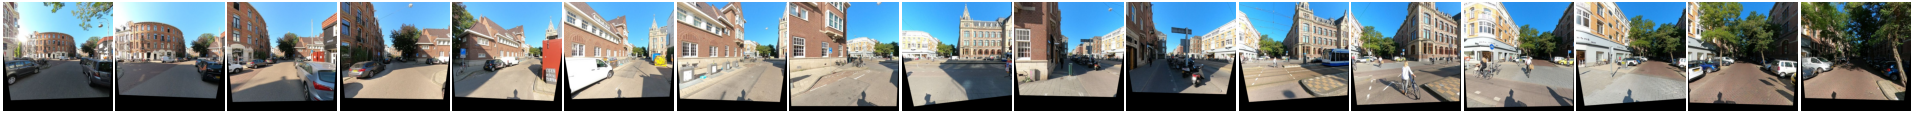

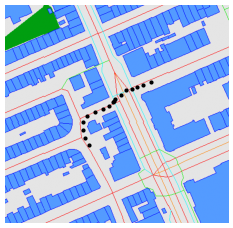

In [7]:
# chunk_key = [c for c in chunk2idx if not c[0].endswith(('back', 'left', 'right'))][2]
chunk_key = ('xxkv8r6bxnjx0w5lqfpsmb_front', 0)
indices = chunk2idx[chunk_key]
batches = [dset[i] for i in indices]
plot_images([b['image'].permute(1, 2, 0) for b in batches], dpi=25)

from maploc.data.sequential import unpack_batches
images, canvas, maps, yaws_gt, uv_gt, xy_gt, xy_gps = unpack_batches(batches)
maps = list(map(Colormap.apply, maps))

location = dset.names[indices][0][0]
latlon_gps = dset.data['gps_position'][indices]
xy_gps = dset.tile_managers[location].projection.project(latlon_gps)
from maploc.utils.geo import BoundaryBox
bbox_seq = BoundaryBox(xy_gps.min(0), xy_gps.max(0)) + dset.cfg.crop_size_meters + 16
canvas_total = dset.tile_managers[location].query(bbox_seq)
map_total = Colormap.apply(canvas_total.raster)
plot_images([map_total], dpi=50)
plt.scatter(*canvas_total.to_uv(xy_gps).T, c='black', lw=0);

## Run inference and visualize

100%|█████████████████████████████████████████████████████| 17/17 [00:05<00:00,  2.91it/s]


xy error single vs seq:
[[52.045448303222656, 52.045448303222656],
 [1.3979885578155518, 0.9280917644500732],
 [0.7784335613250732, 0.2786642909049988],
 [0.7369937300682068, 0.14744560420513153],
 [0.8737768530845642, 0.4182710647583008],
 [1.1743152141571045, 0.3935284912586212],
 [0.4425593912601471, 0.11395631730556488],
 [1.5002132654190063, 0.1270245909690857],
 [4.8105573654174805, 0.49915611743927],
 [36.241886138916016, 0.8015122413635254],
 [2.323115348815918, 0.4433805048465729],
 [1.4630084037780762, 0.4912501871585846],
 [1.8731886148452759, 0.43401700258255005],
 [1.0220516920089722, 0.8244059681892395],
 [1.1451472043991089, 0.5104449987411499],
 [32.78706359863281, 0.7883806824684143],
 [59.77032470703125, 0.4612651467323303]]
yaw error single vs seq:
[[87.3751220703125, 87.3751220703125],
 [2.894500732421875, 1.488250732421875],
 [0.535308837890625, 0.870941162109375],
 [0.504852294921875, 0.901397705078125],
 [0.8300437927246094, 0.5762062072753906],
 [2.255859375, 0.

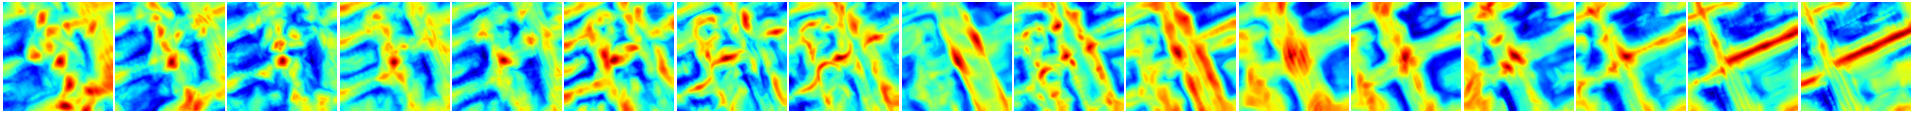

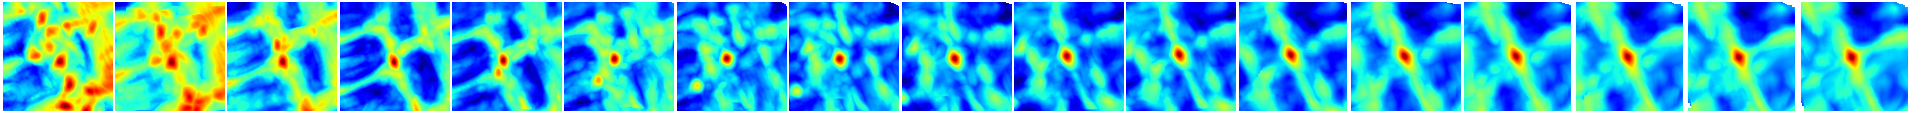

In [13]:
from maploc.data.torch import collate, unbatch_to_device
from tqdm import tqdm
from maploc.models.sequential import RigidAligner, log_softmax_spatial
aligner = RigidAligner(num_rotations=model.model.conf.num_rotations)
aligner2 = RigidAligner(num_rotations=model.model.conf.num_rotations)
preds = []
for data in tqdm(batches):
    batch = model.transfer_batch_to_device(collate([data]), model.device, 0)
    pred = model(batch)
    xy = data['canvas'].to_xy(batch["uv"].squeeze(0).double())
    yaw = batch["roll_pitch_yaw"].squeeze(0)[-1].double()
    aligner.update_with_ref(pred['scores'][0], data['canvas'], xy, yaw)
#     aligner2.update(pred['log_probs'][0], canvas, xy, yaw)
    pred = unbatch_to_device(pred)
    pred['log_probs_seq'] = log_softmax_spatial(aligner.belief).cpu()
    pred['xyr_max_seq'] = argmax_xyr(pred['log_probs_seq'])
    preds.append(pred)
    del pred
    
uvt_p = torch.stack([p["uvr_max"] for p in preds])
uvt_seq = torch.stack([p["uvr_max_seq"] for p in preds])
xy_p = torch.stack([c.to_xy(uv) for c, uv in zip(canvas, uvt_p[:,:2])])
xy_seq = torch.stack([c.to_xy(uv) for c, uv in zip(canvas, uvt_seq[:,:2])])
logprobs = torch.stack([p["log_probs"] for p in preds])
logprobs_seq = torch.stack([p["log_probs_seq"] for p in preds])

from maploc.models.metrics import angle_error
err_xy = torch.norm(uv_gt - uvt_p[:, :2], dim=1)/dataset.cfg.pixel_per_meter
err_yaw = angle_error(yaws_gt, uvt_p[:, 2])
err_xy_seq = torch.norm(uv_gt - uvt_seq[:, :2], dim=1)/dataset.cfg.pixel_per_meter
err_yaw_seq = angle_error(yaws_gt, uvt_seq[:, 2])

plot_images([lp.max(-1).values for lp in logprobs], cmaps="jet", dpi=25)
plot_images([lp.max(-1).values for lp in logprobs_seq], cmaps="jet", dpi=25)

print('xy error single vs seq:')
pprint(torch.stack([err_xy, err_xy_seq], -1).numpy().tolist())
print('yaw error single vs seq:')
pprint(torch.stack([err_yaw, err_yaw_seq], -1).numpy().tolist())

In [ ]:
def bbox_to_extent(bbox):
    return np.r_[bbox.min_, bbox.max_][[0,2,1,3]]

show_heatmap = lambda p: likelihood_overlay(p.max(-1).values.exp().numpy(), p_rgb=0.02, p_alpha=1/50)

map_gray = map_total.mean(-1)
xy_gt = dset.data['t_c2w'][indices][:, :2]
for idx, (im, xy_gt_, b, lp, lps) in enumerate(zip(images, xy_gt, batches, logprobs, logprobs_seq)):
    plot_images([im]+[map_gray]*2, titles=['input image', 'single image', 'sequential'])
    axes = plt.gcf().axes
    for ax in axes[1:]:
        ax.plot(*xy_gt.T, c='blue', lw=1, marker='o', ms=5, mfc='none')
        ax.images[0].set_extent(bbox_to_extent(canvas_total.bbox))
        ax.autoscale(enable=False)
    for ax, xy_ in zip(axes[1:], [xy_p, xy_seq]):
        ax.plot(*xy_[:idx+1].T, c='red', lw=1, marker='o', ms=5)
    bbox = b['canvas'].bbox
    axes[1].imshow(show_heatmap(lp), alpha=1.0, cmap='jet', extent=bbox_to_extent(bbox), zorder=10)
    axes[2].imshow(show_heatmap(lps), alpha=1.0, cmap='jet', extent=bbox_to_extent(bbox), zorder=10)
    axins = add_circle_inset(axes[2], xy_gt_);
    axins.scatter(*xy_gt_, c='none', zorder=10, ec='blue', s=70)